In [1]:
from datetime import datetime
import psycopg2
from astral import Observer
from astral.sun import sun
from radiospectra.sources import CallistoSpectrogram
import pandas as pd
import numpy as np
import config as ecallisto_config

/tmp/pycharm_project_276/validation/rating_stars/radiospectra/version.py:12: UserWarning: could not determine radiospectra package version; this indicates a broken installation
  warnings.warn(


In [2]:
def _get_db():
        """
        Connects to the database and returns a database connection object.

        Returns:
            psycopg2.extensions.connection: The database connection object.
        """
        database = psycopg2.connect(
            host=ecallisto_config.DB_HOST,
            user=ecallisto_config.DB_USER,
            database=ecallisto_config.DB_DATABASE,
            port=ecallisto_config.DB_PORT,
            password=ecallisto_config.DB_PASSWORD
        )
        return database

In [3]:
import pandas as pd
def convert_to_stars(score):
    ranking = [1.0, 2.0, 3.0, 4.0, 5.0]

    # Compute the percentile of the data
    percent = np.percentile(score, [0, 25, 50, 75, 100])
    rating = np.interp(score, percent, ranking)
    rating = np.round(rating, 2)

    return rating


def _get_all_instruments(start_date, end_date):
    """
    Retrieves instrument data from the database between the given start_date and end_date.

    Args:
        start_date (str): Start date in the format 'YYYY-MM-DD HH:MM:SS'.
        end_date (str): End date in the format 'YYYY-MM-DD HH:MM:SS'.

    Returns:
        list: List of instrument data.
    """
    database = _get_db()

    sql_query_instruments = """
    SELECT *, lower(observation_times) AS start_date, upper(observation_times) AS end_date
    FROM test
    WHERE observation_times && tsrange(%s, %s) AND snr IS NOT NULL
    ORDER BY snr DESC;
        """

    with database.cursor() as cursor:
        cursor.execute(sql_query_instruments, (start_date, end_date))
        instruments = cursor.fetchall()

    return instruments





def get_station_files(start_date, end_date, station_name):
    rows = _get_all_instruments(start_date, end_date)
    result = []

    for row in rows:
        spec = CallistoSpectrogram.read(ecallisto_config.DATA_PATH + row[6])
        file_station_name = spec.header['INSTRUME']

        if file_station_name == station_name:
            file_name = row[6]
            std = row[4]
            snr = row[5]
            result.append((file_name, file_station_name, std, snr))

    columns = ['File Name', 'Station Name','SNR', 'Std']



    df = pd.DataFrame(result, columns=columns)

    df['snr_rating'] = convert_to_stars(df['SNR'])
    df['std_rating'] = convert_to_stars(df['Std'])

    return df


start_date = '2022-03-08 14:30:03'
end_date = '2022-03-09 14:30:03'
station_name = 'INDONESIA'
df = get_station_files(start_date, end_date, station_name)

In [4]:
df

File Name Station Name    SNR  \
0   /2022/03/09/INDONESIA_20220309_024501_59.fit.gz    INDONESIA  0.520   
1   /2022/03/09/INDONESIA_20220309_020001_59.fit.gz    INDONESIA  0.523   
2   /2022/03/09/INDONESIA_20220309_021501_59.fit.gz    INDONESIA  0.532   
3   /2022/03/09/INDONESIA_20220309_033001_59.fit.gz    INDONESIA  0.536   
4   /2022/03/09/INDONESIA_20220309_014501_59.fit.gz    INDONESIA  0.529   
5   /2022/03/09/INDONESIA_20220309_031501_59.fit.gz    INDONESIA  0.539   
6   /2022/03/09/INDONESIA_20220309_023001_59.fit.gz    INDONESIA  0.552   
7   /2022/03/09/INDONESIA_20220309_030001_59.fit.gz    INDONESIA  0.544   
8   /2022/03/09/INDONESIA_20220309_074500_59.fit.gz    INDONESIA  0.623   
9   /2022/03/09/INDONESIA_20220309_000001_59.fit.gz    INDONESIA  0.552   
10  /2022/03/09/INDONESIA_20220309_001501_59.fit.gz    INDONESIA  0.553   
11  /2022/03/08/INDONESIA_20220308_233001_59.fit.gz    INDONESIA  0.555   
12  /2022/03/09/INDONESIA_20220309_073000_59.fit.gz    INDONESIA  0.645   
13  /2022/03/09/INDONESIA_20220309_003001_59.fit.gz    INDONESIA  0.560   
14  /2022/03/09/INDONESIA_20220309_071500_59.fit.gz    INDONESIA  0.677   
15  /2022/03/08/INDONESIA_20220308_234501_59.fit.gz    INDONESIA  0.612   
16  /2022/03/09/INDONESIA_20220309_104500_59.fit.gz    INDONESIA  0.629   
17  /2022/03/09/INDONESIA_20220309_034501_59.fit.gz    INDONESIA  0.639   
18  /2022/03/08/INDONESIA_20220308_231500_59.fit.gz    INDONESIA  0.590   
19  /2022/03/09/INDONESIA_20220309_083000_59.fit.gz    INDONESIA  0.666   
20  /2022/03/09/INDONESIA_20220309_013001_59.fit.gz    INDONESIA  0.622   
21  /2022/03/09/INDONESIA_20220309_004501_59.fit.gz    INDONESIA  0.625   
22  /2022/03/08/INDONESIA_20220308_230000_59.fit.gz    INDONESIA  0.612   
23  /2022/03/09/INDONESIA_20220309_010001_59.fit.gz    INDONESIA  0.636   
24  /2022/03/09/INDONESIA_20220309_081500_59.fit.gz    INDONESIA  0.714   
25  /2022/03/09/INDONESIA_20220309_101500_59.fit.gz    INDONESIA  0.684   
26  /2022/03/09/INDONESIA_20220309_080000_59.fit.gz    INDONESIA  0.742   
27  /2022/03/09/INDONESIA_20220309_091500_59.fit.gz    INDONESIA  0.719   
28  /2022/03/09/INDONESIA_20220309_053001_59.fit.gz    INDONESIA  0.721   
29  /2022/03/09/INDONESIA_20220309_103000_59.fit.gz    INDONESIA  0.706   
30  /2022/03/09/INDONESIA_20220309_084500_59.fit.gz    INDONESIA  0.736   
31  /2022/03/09/INDONESIA_20220309_093000_59.fit.gz    INDONESIA  0.730   
32  /2022/03/09/INDONESIA_20220309_051501_59.fit.gz    INDONESIA  0.751   
33  /2022/03/09/INDONESIA_20220309_044501_59.fit.gz    INDONESIA  0.744   
34  /2022/03/09/INDONESIA_20220309_090000_59.fit.gz    INDONESIA  0.755   
35  /2022/03/09/INDONESIA_20220309_063000_59.fit.gz    INDONESIA  0.810   
36  /2022/03/09/INDONESIA_20220309_050001_59.fit.gz    INDONESIA  0.760   
37  /2022/03/09/INDONESIA_20220309_054501_59.fit.gz    INDONESIA  0.792   
38  /2022/03/09/INDONESIA_20220309_070000_59.fit.gz    INDONESIA  0.871   
39  /2022/03/09/INDONESIA_20220309_094500_59.fit.gz    INDONESIA  0.831   
40  /2022/03/09/INDONESIA_20220309_043001_59.fit.gz    INDONESIA  0.792   
41  /2022/03/09/INDONESIA_20220309_061500_59.fit.gz    INDONESIA  0.897   
42  /2022/03/09/INDONESIA_20220309_100000_59.fit.gz    INDONESIA  0.846   
43  /2022/03/09/INDONESIA_20220309_064500_59.fit.gz    INDONESIA  0.978   
44  /2022/03/09/INDONESIA_20220309_011501_59.fit.gz    INDONESIA  0.927   
45  /2022/03/09/INDONESIA_20220309_040001_59.fit.gz    INDONESIA  1.195   

      Std  snr_rating  std_rating  
0   1.183        1.00        5.00  
1   1.175        1.06        4.91  
2   1.169        1.25        4.84  
3   1.166        1.34        4.81  
4   1.163        1.19        4.77  
5   1.152        1.40        4.65  
6   1.137        1.67        4.48  
7   1.132        1.51        4.42  
8   1.115        2.53        4.23  
9   1.111        1.67        4.19  
10  1.104        1.69        4.11  
11  1.096        1.74        4.02  
12  1.090        2.75        3.95  
13  1.079   

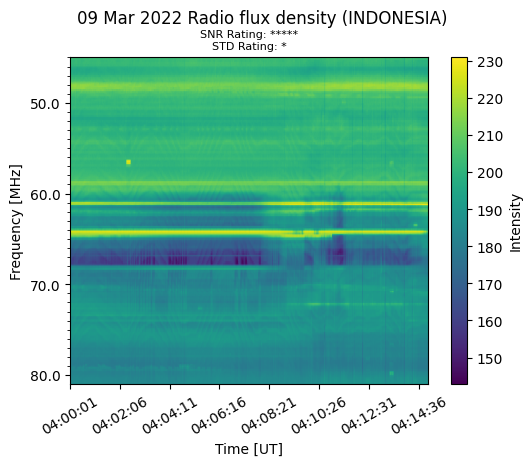

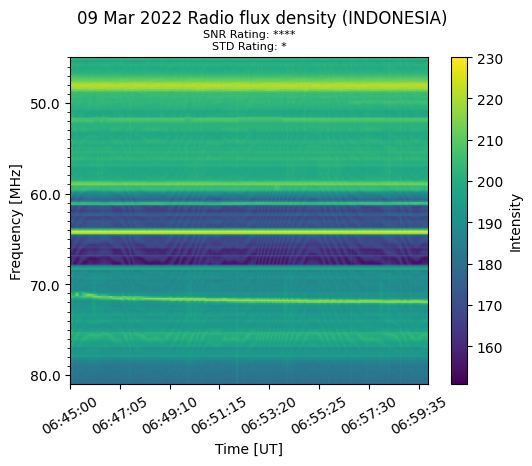

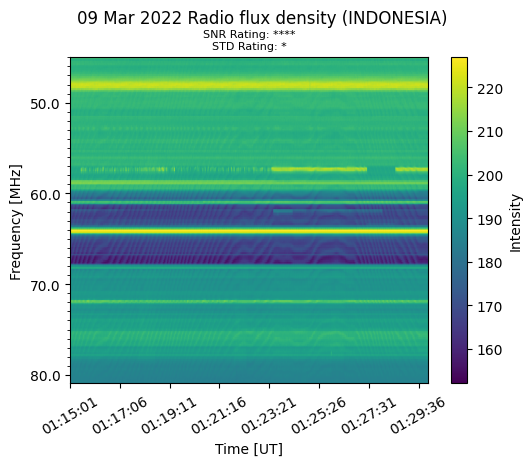

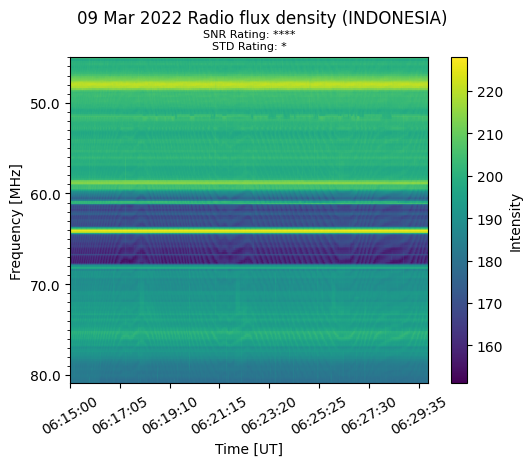

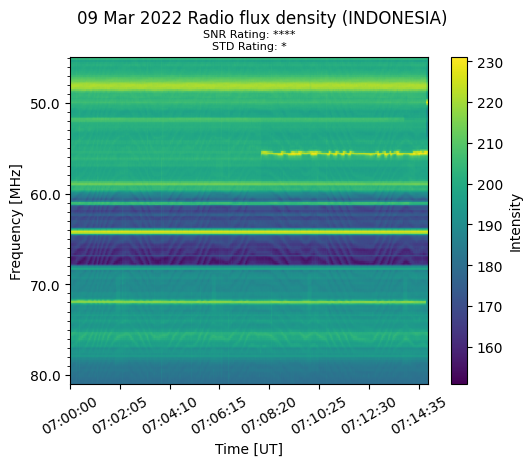

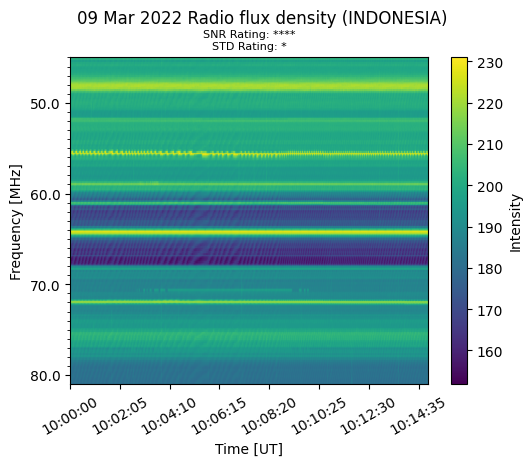

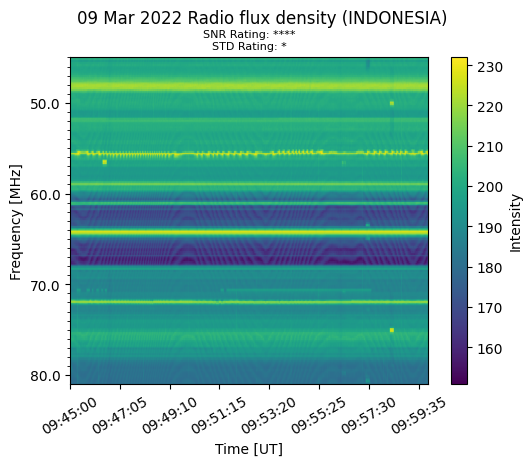

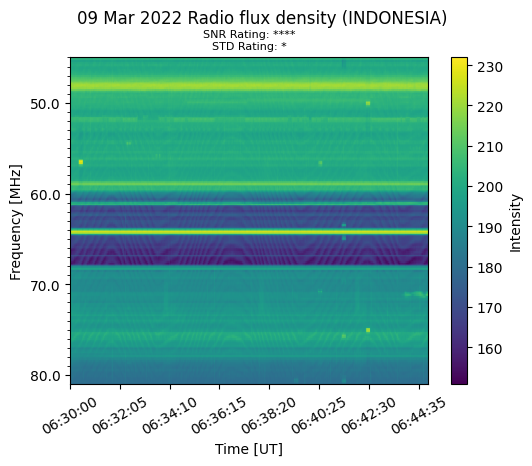

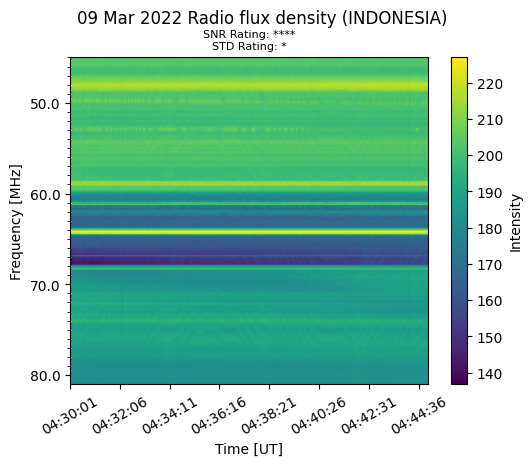

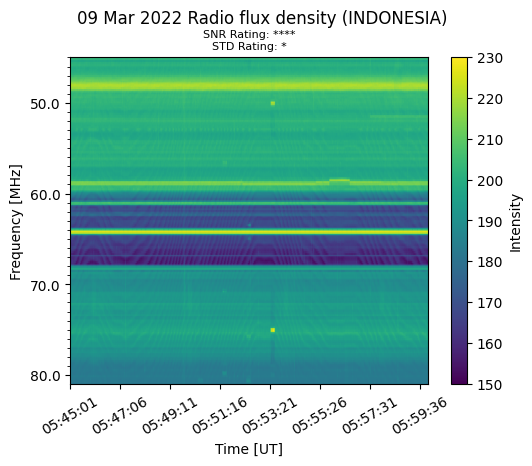

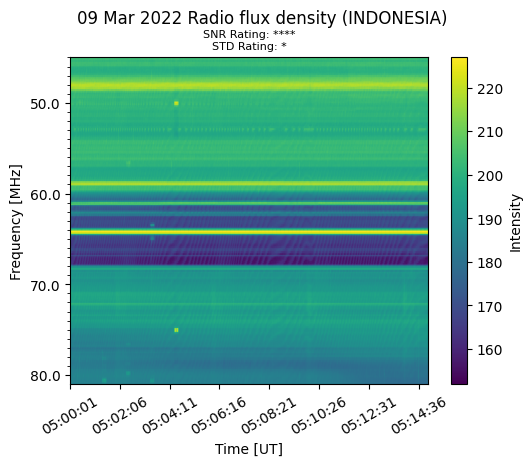

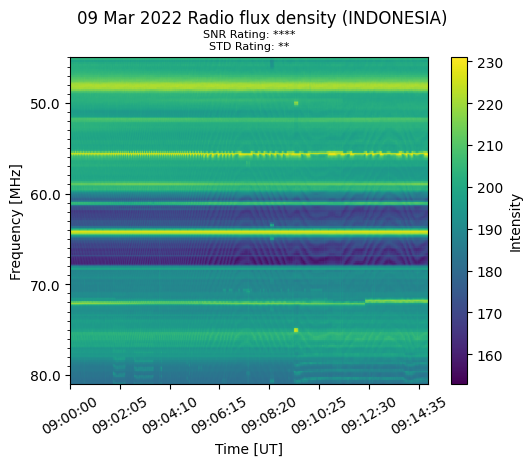

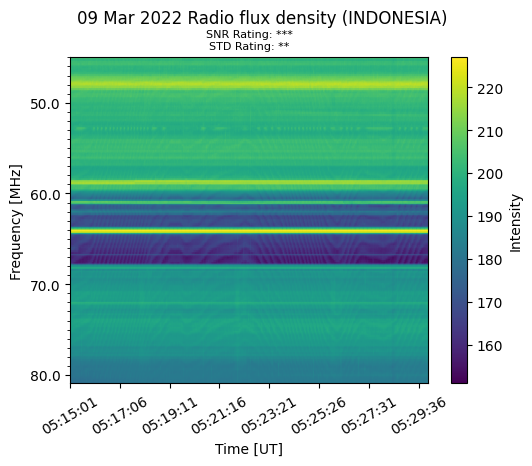

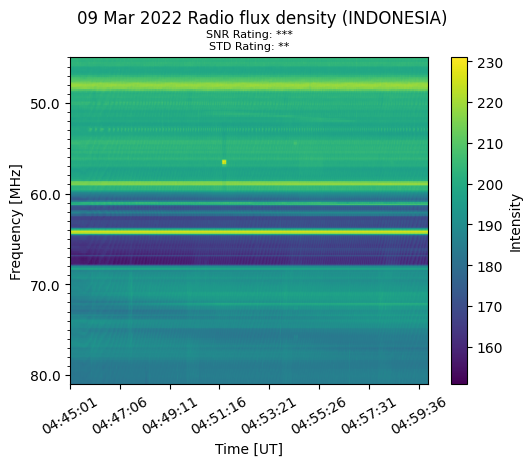

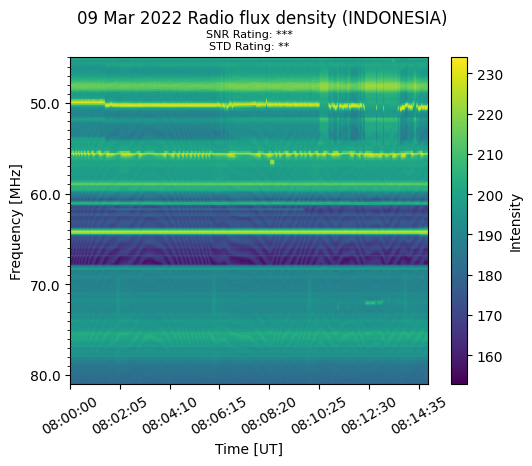

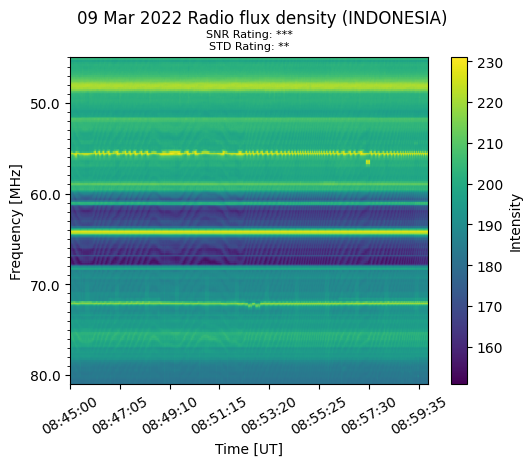

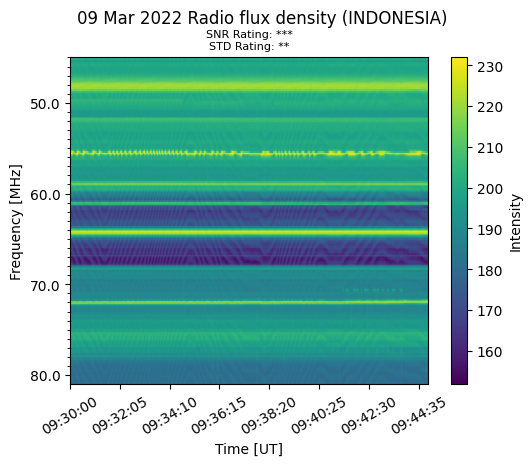

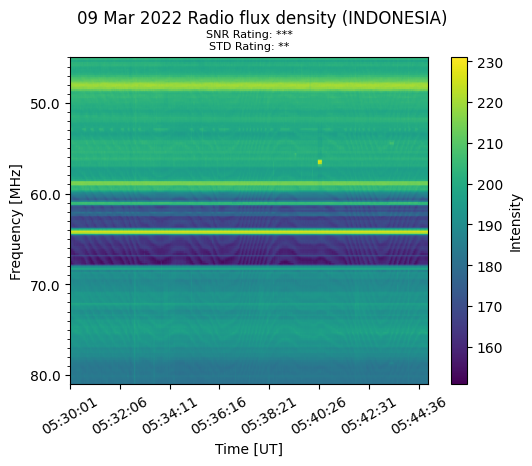

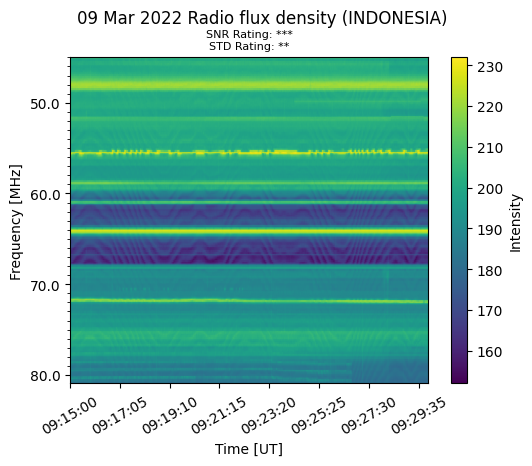

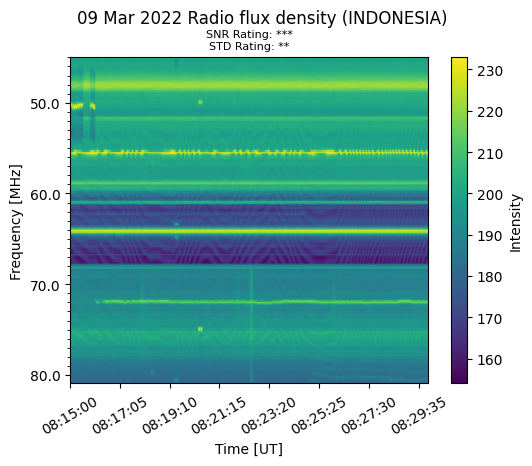

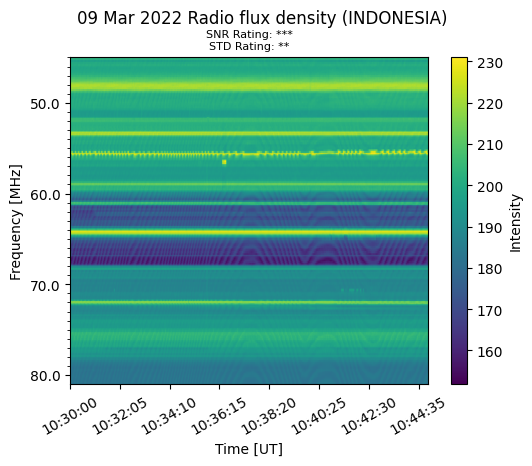

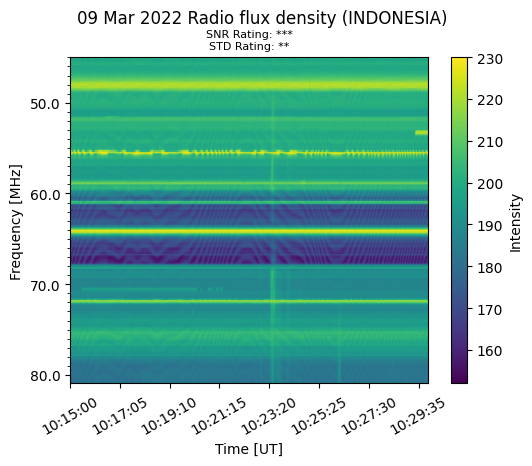

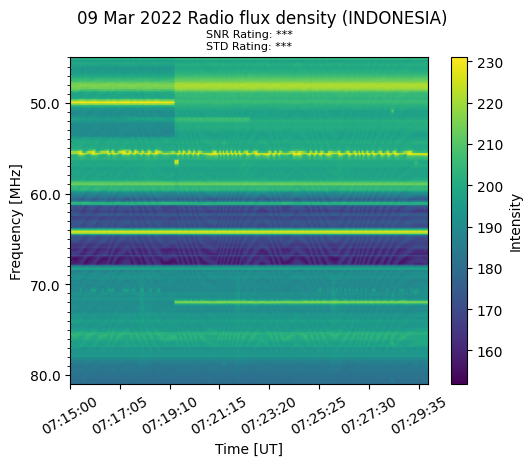

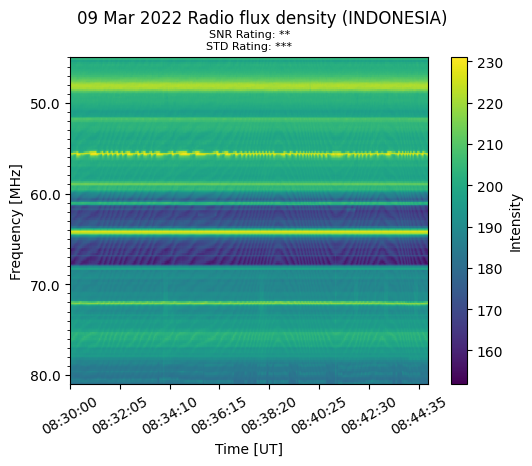

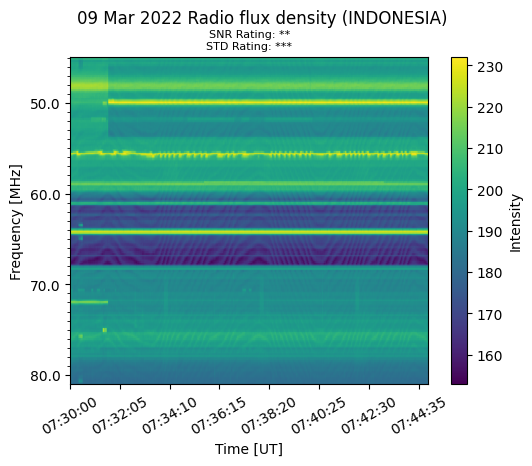

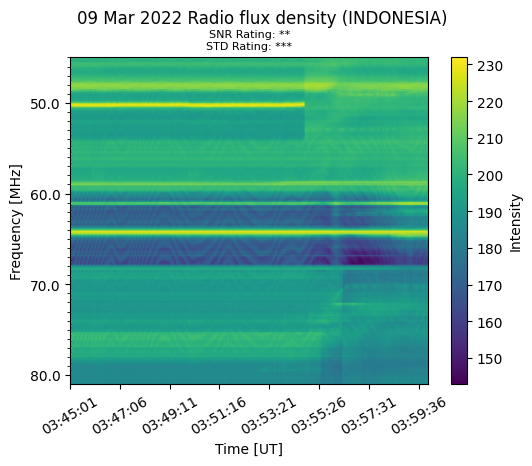

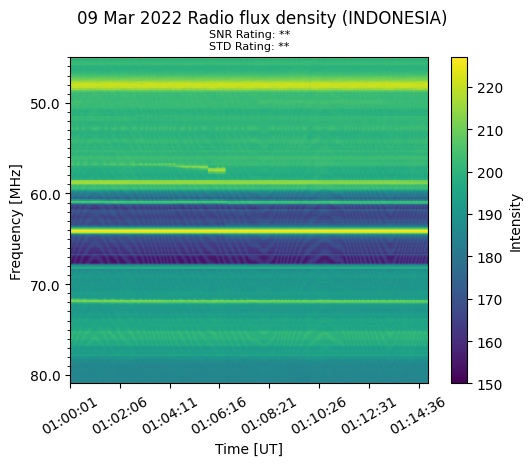

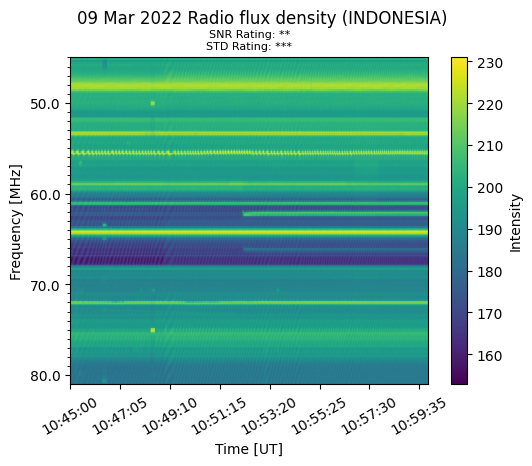

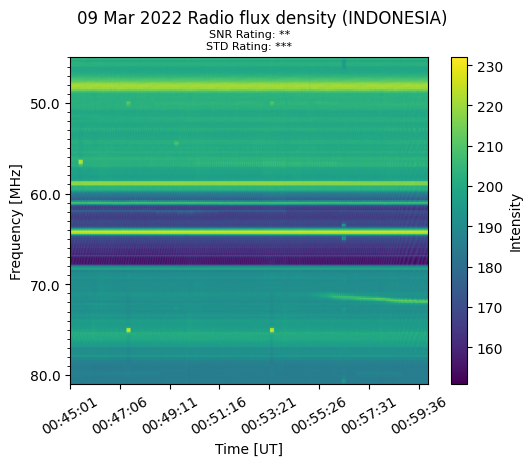

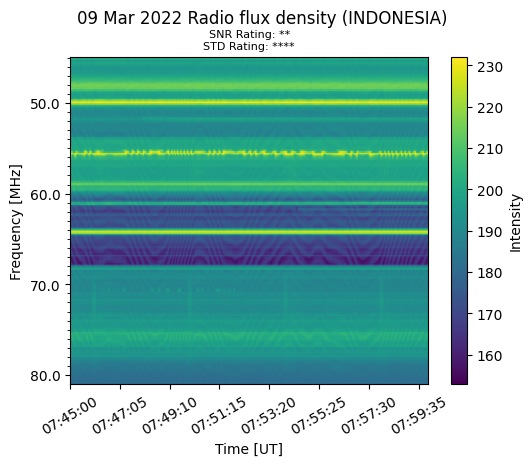

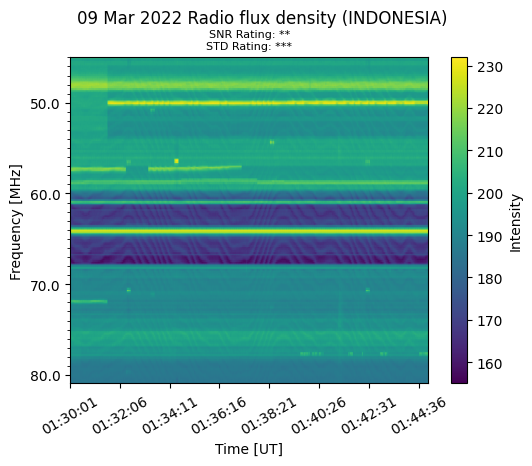

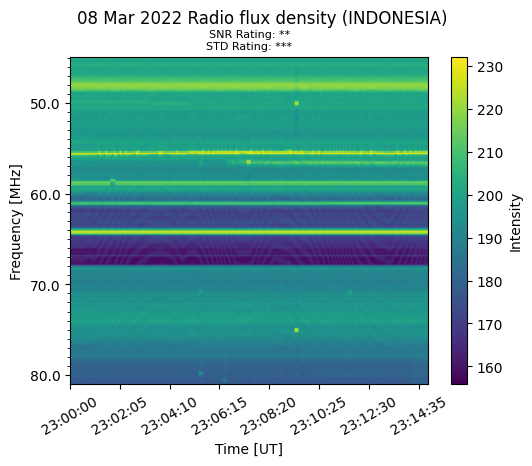

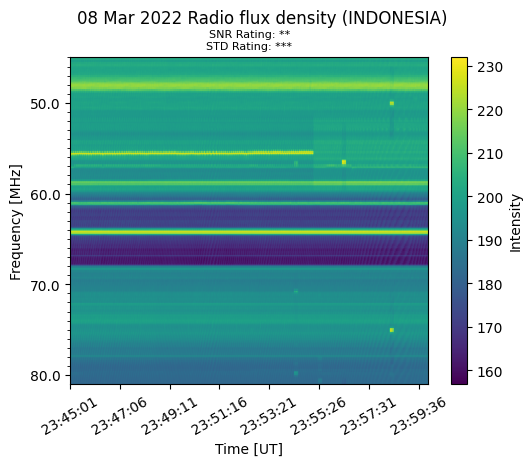

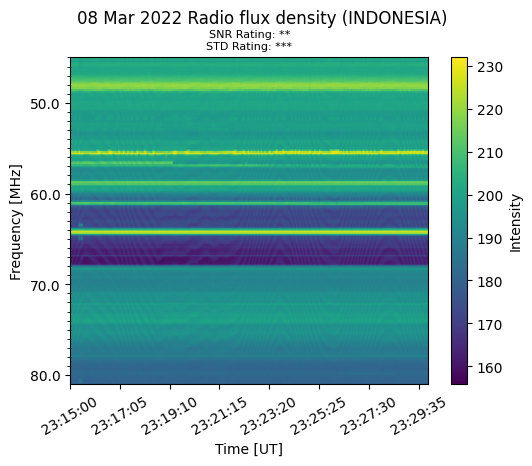

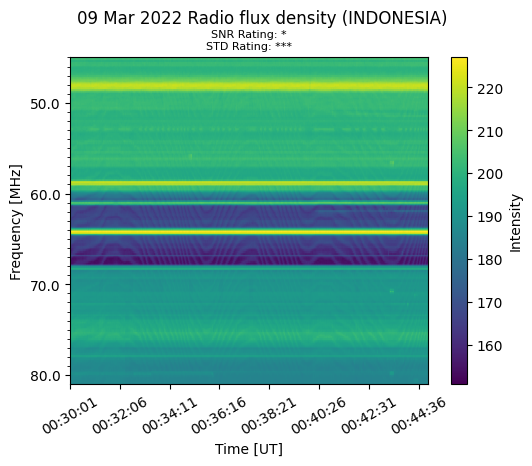

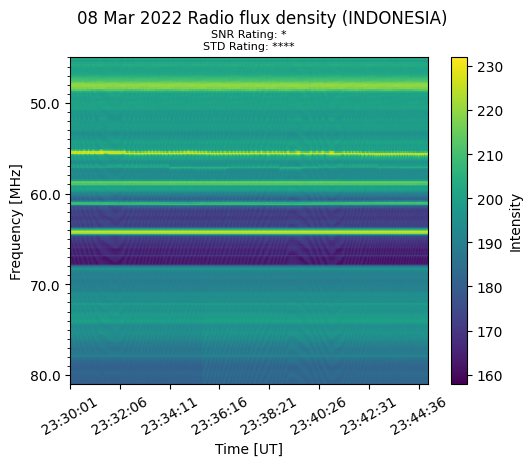

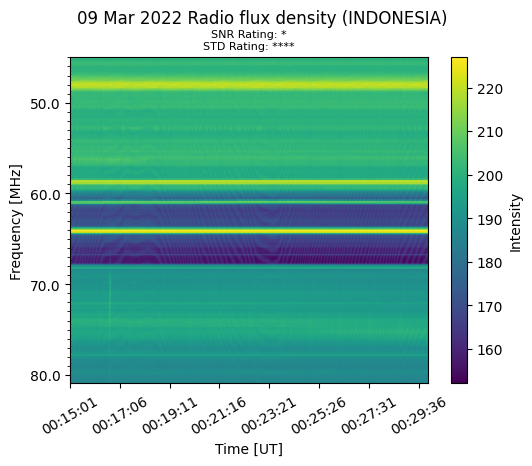

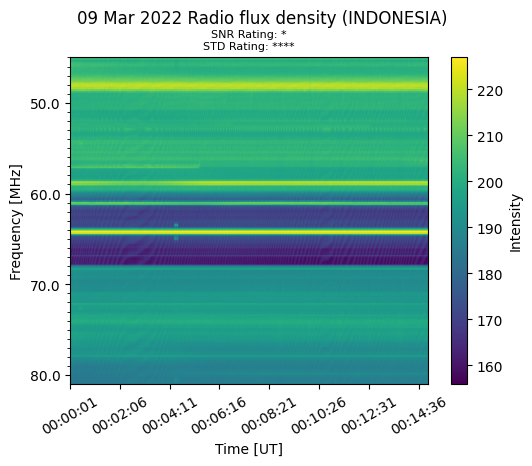

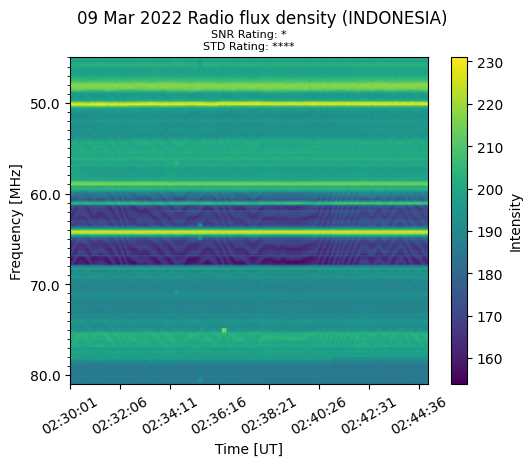

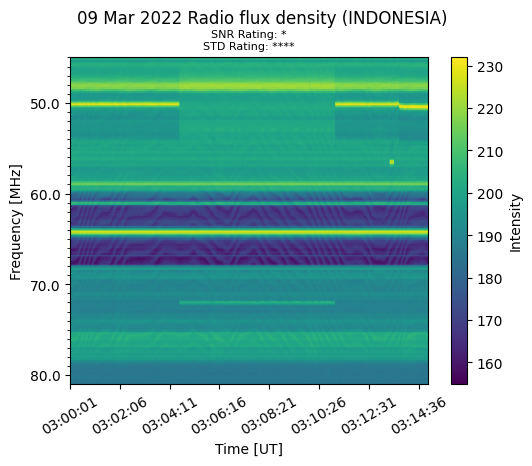

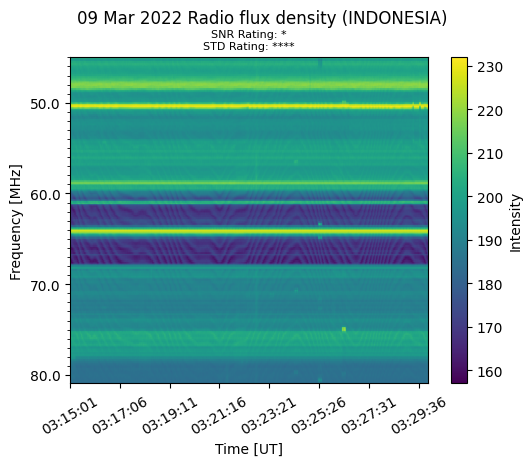

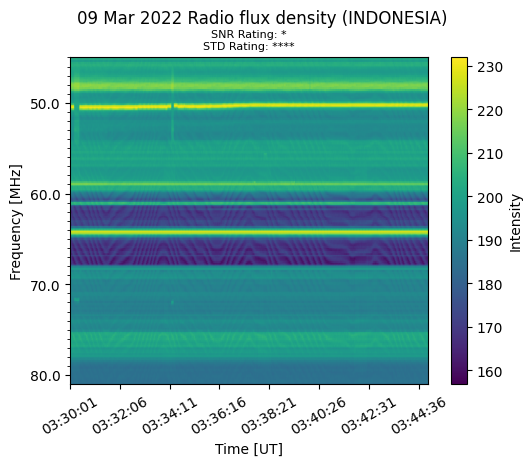

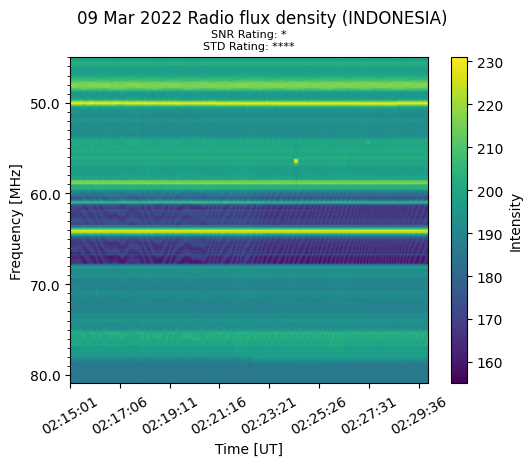

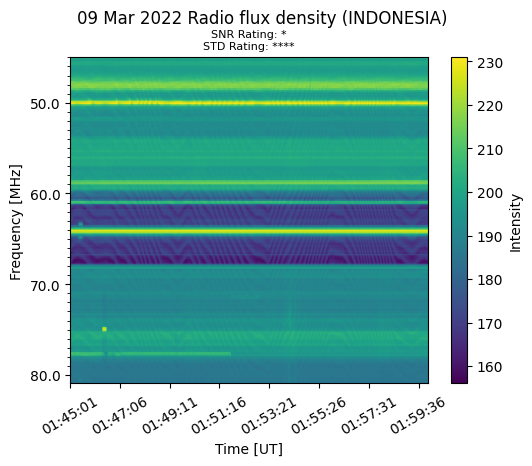

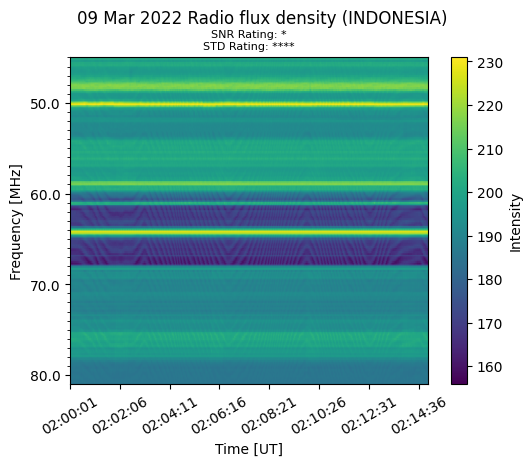

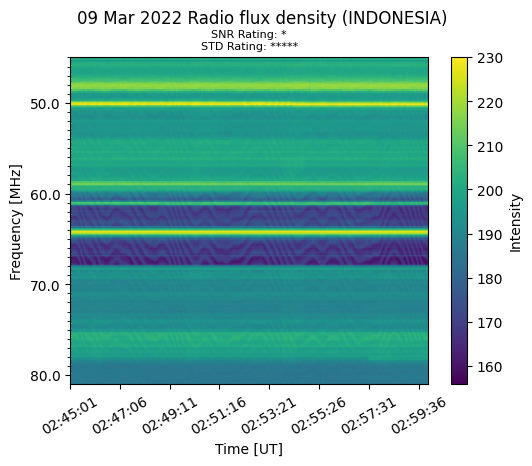

In [6]:
import matplotlib.pyplot as plt

def add_rating_stars(rating):
    # Convert rating to integer and calculate number of stars
    num_stars = int(rating)
    stars = "*" * num_stars
    return stars

def create_spectrogram_plots(df):
    # Sort the DataFrame by 'SNR Rating' in descending order
    df_sorted = df.sort_values(by='snr_rating', ascending=False).reset_index(drop=True)

    for index, row in df_sorted.iterrows():
        file_name = row['File Name']
        station_name = row['Station Name']
        std_rating = row['std_rating']
        snr_rating = row['snr_rating']

        # Assuming CallistoSpectrogram has a method `plot()` to plot the spectrogram
        spec = CallistoSpectrogram.read(ecallisto_config.DATA_PATH + file_name)
        fig, ax = plt.subplots()
        spec.plot()
        ax.set_title(f"SNR Rating: {add_rating_stars(snr_rating)}\nSTD Rating: {add_rating_stars(std_rating)}", fontsize=8)
        plt.show()

# Assuming you have the DataFrame 'df' with columns 'File Name', 'Station Name', 'Std Rating', and 'SNR Rating'
create_spectrogram_plots(df)
